# Homework 1 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ dataset as we see in two exercises. 

Try to use as much as HiveQL as possible and use pandas operations only when it's necessary.

__Hand-in:__
- __Due: 24.03.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your queries readable


__Cluster Usage__

As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.

__Documentation__

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>


In [30]:
import os
import warnings
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline

from pyhive import hive
username = os.environ['JUPYTERHUB_USER']
# create connection
conn = hive.connect(host='iccluster059.iccluster.epfl.ch', port=10000, username=username) 
# create cursor
cur = conn.cursor()

## Data from SBB/CFF/FFS

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

### Question I.a - 5 Points

In the exercise, you were asked to find how many stops of each type of transportation for the date 05.11.2018. Now, let's do the same for the whole dataset. 

Show the results with a stacked bar chart (you can use `pandas` to create a pivot table if necessary). Document any patterns you can see.

__Hint__: 
- To properly order by date, you may have to parse them using the `unix_timestamp` function.
- When using `pd.read_sql(query, conn, ...)` to retrieve the query results, there is one `parse_dates` argument for date parsing.
- If you think it is not nice to display all the data in one plot, you can select a small period of data, i.e. 3 months, for visualization to detect the pattern.

In [2]:
# pick data of Jan. 2018 & Jan. 2019
query = """
    select unix_timestamp(BETRIEBSTAG,"dd.MM.yy") as xdate, lower(PRODUKT_ID) as ttype, count(*) as stops
    from {0}.sbb_orc
    where BETRIEBSTAG like '%01_201_'
    group by BETRIEBSTAG,lower(PRODUKT_ID)
    order by xdate, ttype asc
""".format(username)
df_type = pd.read_sql(query, conn, parse_dates={'xdate': 's'})

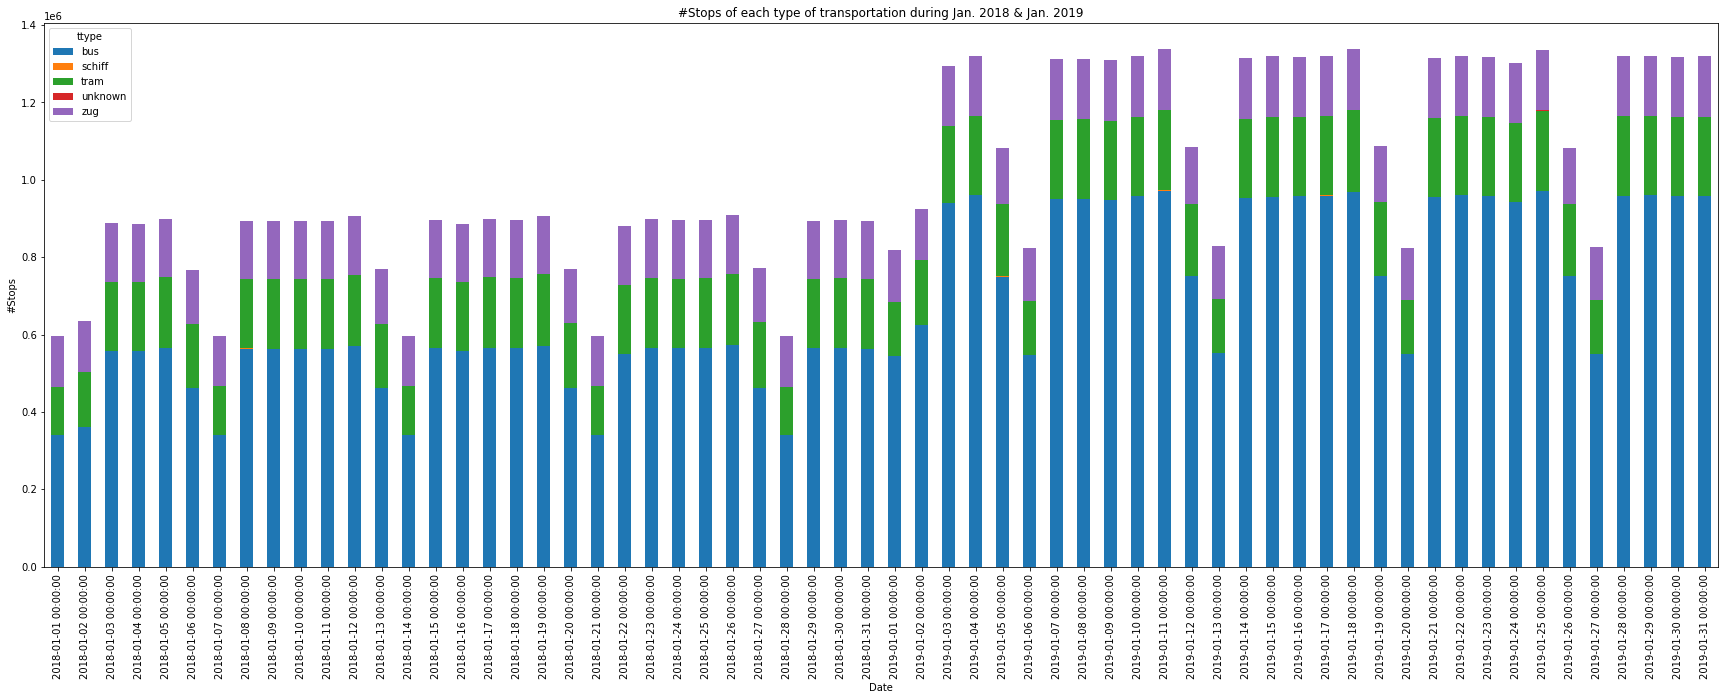

In [3]:
# Pivot table
# Fill missing value with 0
# Name missing column as "unknown"
df_type.replace('', 'unknown', inplace=True)
df_1mtype = df_type.pivot(index='xdate',columns='ttype',values='stops').fillna(0)

# Plot stackedbar chart
df_1mtype.plot(kind='bar', stacked=True,figsize=(30,10),title="#Stops of each type of transportation during Jan. 2018 & Jan. 2019")
plt.xlabel("Date")
plt.ylabel("#Stops")
plt.show()

**Answer** 

From the vertical view of the chart, we can see the five means of transportation have distinct proportion of stops during one day. The rank of transportation with most stop in ascending order would be:Bus,Tram,Train and the other two(tiny proportion). We can interpret this by the fact that bus has short distance between two stops and tend to have more stops than Train. But it’s not enough to conclude from the chart bus are the most important means of transportation in SBB system.

From the horizontal view of the stacked bar chart, we can first observe a periodicity in terms of the fluctuation of the number of stops per day(and not constant,which shows the flexibility and adaption of SBB’s transport schedule rangement to different days of month). 

A weekly periodicity is apparent and is marked by a stable number of stops in weekdays and a strong incremental decrease in the weekend. This means SBB has intentionally decrease the number of stops on weekend, due to the less passenger flux. 
We can see a step jump between january 2018 and january 2019 . There are 30% more stops in total in january 2019 than in january  2018. There must have been a strong augmentation of frequency of buses in sbb during 2018,because the increase only comes from buses.

Finally, one can observe that in the new year 2018 and new year 2019, the number of stops are significantly lower than on usual days. The reason should be similar to that of weekend: less people take transportation and fewer workers as well.

### Question I.b - 10 Points

Get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on a typical week day (not Saturday, not Sunday, not a bank holiday). Display the train number (`LINIEN_ID`) as well as the schedule of the trains.

__Note:__ do not hesitate to create intermediary tables. You can use the advanced search of SBB's website to check your answer, the schedule of IC from Genève to Lausanne has not changed.

In [6]:
# create table with one-day data (Dec. 05, 2018)
query = """
    drop table if exists {0}.sbb_05_12_2018
""".format(username)
cur.execute(query)

query='''
create table {0}.sbb_05_12_2018 
stored as orc
as (
    select * from {0}.sbb_orc
    where BETRIEBSTAG ='05.12.2018'
)
'''.format(username)
cur.execute(query)

In [7]:
# Create table for IC trains stopped at Geneve & Lausanne
query = """
    create table {0}.sbb_IC_workday_gen
    stored as orc
    as 
        select *
        from {0}.sbb_05_12_2018
        where VERKEHRSMITTEL_TEXT like 'IC' and HALTESTELLEN_NAME like 'Gen_ve' 
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_IC_workday_lau
    stored as orc
    as 
        select *
        from {0}.sbb_05_12_2018
        where VERKEHRSMITTEL_TEXT like 'IC' and HALTESTELLEN_NAME like 'Lausanne'
""".format(username)
cur.execute(query)

In [8]:
# Combined the schedule in Geneve and that in Lausanne. To find the train from Geneve to Lausanne,
# the train id should be the same and the departure time in Geneve should be ealier than the arrival
# time in Lausanne. The number of schedule is display in the following.
query = """
    with sbb_GV as (
        select LINIEN_ID, unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm') as dep from {0}.sbb_IC_workday_gen
    ),
    sbb_LAU as(
        select LINIEN_ID, unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yy HH:mm') as arr from {0}.sbb_IC_workday_lau
    ) 
    select sbb_GV.LINIEN_ID as ID, sbb_GV.dep as dep_Geneve,  sbb_LAU.arr as arr_Lausanne
    from sbb_GV, sbb_LAU
    where sbb_GV.LINIEN_ID = sbb_LAU.LINIEN_ID and sbb_GV.dep < sbb_LAU.arr
    order by dep_Geneve
""".format(username)
df_IC_schedule = pd.read_sql(query,conn,parse_dates=['dep_geneve','arr_lausanne'])
df_IC_schedule

,id,dep_geneve,arr_lausanne
0,707,2018-12-05 05:42:00,2018-12-05 06:18:00
1,709,2018-12-05 06:42:00,2018-12-05 07:18:00
2,711,2018-12-05 07:42:00,2018-12-05 08:18:00
3,713,2018-12-05 08:42:00,2018-12-05 09:18:00
4,715,2018-12-05 09:42:00,2018-12-05 10:18:00
5,717,2018-12-05 10:42:00,2018-12-05 11:18:00
6,719,2018-12-05 11:42:00,2018-12-05 12:18:00
7,721,2018-12-05 12:42:00,2018-12-05 13:18:00
8,723,2018-12-05 13:42:00,2018-12-05 14:18:00
9,725,2018-12-05 14:42:00,2018-12-05 15:18:00


### Question I.c - 10 Points

In the exercise, we discussed a little bit about two interesting status, `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`. We will continue here to see how things evolved in the past two years.

i) Please show us how the monthly distribution of `AN_PROGNOSE_STATUS` (arrival forcast status) for __IC 733__ train at the Lausanne station changes over time, i.e., how many of them are REAL, GESCHAETZT, etc. in every month. Use `pandas` to create a pivot table if necessary.

In [12]:
# Create table for IC 733 at Lausanne
query = """
    drop table if exists {0}.sbb_IC733_LAU
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_IC733_LAU
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT like 'IC' and LINIEN_ID = 733 and HALTESTELLEN_NAME like 'Lausanne'
""".format(username)
cur.execute(query)

In [9]:
# Cast the date to corresponding month first for grouping.
# Use group by function to count the number of forecast methods used in actual time. The result is showed as follows.
query = """
    with tmp as (
        select date_format(from_unixtime(unix_timestamp(BETRIEBSTAG,"dd.MM.yy")),"yyyyMM") as month, AN_PROGNOSE_STATUS as arr_forcast_status
        from {0}.sbb_IC733_LAU
    )
    select month, arr_forcast_status, count(*) as numof
    from tmp
    group by month,arr_forcast_status
    order by month desc, numof desc
""".format(username)
df_IC733 = pd.read_sql(query,conn)
df_IC733.pivot(index='month',columns='arr_forcast_status',values='numof').fillna(0)

arr_forcast_status,GESCHAETZT,PROGNOSE,REAL
month,,,
201801,30.0,1.0,0.0
201802,27.0,1.0,0.0
201803,28.0,2.0,1.0
201804,22.0,8.0,0.0
201805,6.0,2.0,22.0
201806,0.0,9.0,21.0
201807,0.0,26.0,5.0
201808,0.0,26.0,5.0
201809,0.0,1.0,29.0


ii) Show how the monthly distribution of `AN_PROGNOSE_STATUS` for **all the trains** that arrived at Lausanne station. Document any anything you observed.

In [10]:
# Create table for all trains at Lausanne
query = """
    drop table if exists {0}.sbb_LAU
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_LAU
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where lower(PRODUKT_ID) like 'zug' and HALTESTELLEN_NAME like 'Lausanne'
""".format(username)
cur.execute(query)

In [11]:
# Cast the date to corresponding month first for grouping.
# Use group by function to count the number of forecast methods used in actual time. The result is showed as follows.
query = """
    with tmp as (
        select date_format(from_unixtime(unix_timestamp(BETRIEBSTAG,"dd.MM.yy")),"yyyyMM") as month, AN_PROGNOSE_STATUS as arr_forcast_status
        from {0}.sbb_LAU
    )
    select month, arr_forcast_status, count(*) as numof
    from tmp
    group by month,arr_forcast_status
    order by month desc, numof desc
""".format(username)
df_alltrain = pd.read_sql(query,conn)
df_alltrain.pivot(index='month',columns='arr_forcast_status',values='numof').fillna(0)

arr_forcast_status,GESCHAETZT,PROGNOSE,REAL,UNBEKANNT
month,,,,
201801,13208.0,3595.0,0.0,2.0
201802,12017.0,3270.0,0.0,2.0
201803,12827.0,3743.0,433.0,0.0
201804,11816.0,6199.0,0.0,0.0
201805,2557.0,3579.0,10245.0,0.0
201806,0.0,5469.0,11760.0,0.0
201807,0.0,9518.0,11466.0,0.0
201808,0.0,9464.0,11479.0,3.0
201809,0.0,3665.0,12753.0,0.0


**Answer**

From the table above, following can be observed:

- Until 05.2018 the arrival time in the AN_PROGNOSE column is mostly estimated (GESCHAETZT), sometimes forecasted (PROGNOSE), and never actually measured (REAL) except in 03. 2018.

- Starting from 05.2018, the arrival time in the AN_PROGNOSE column started being mostly actually measured (REAL). Estimation is less used in 05.2018 compared to before and completely abandoned afterwards. Forecast is still used sometimes.

In conclusion, SBB improved the accuracy of the arrival time reported in AN_PROGNOSE starting from 05.2018, i.e., from estimation to real measurement.


### Question I.d - 20 Points

In this question, use __REAL__ for `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`.

i) Display the distribution of delays for the __IC 733__ train at the Lausanne train station. Select the information from the database as a "histogram" with bin size of **one minute** and plot it in a proper way.

__Note:__ when the train is ahead of schedule, count this as a delay of 0.

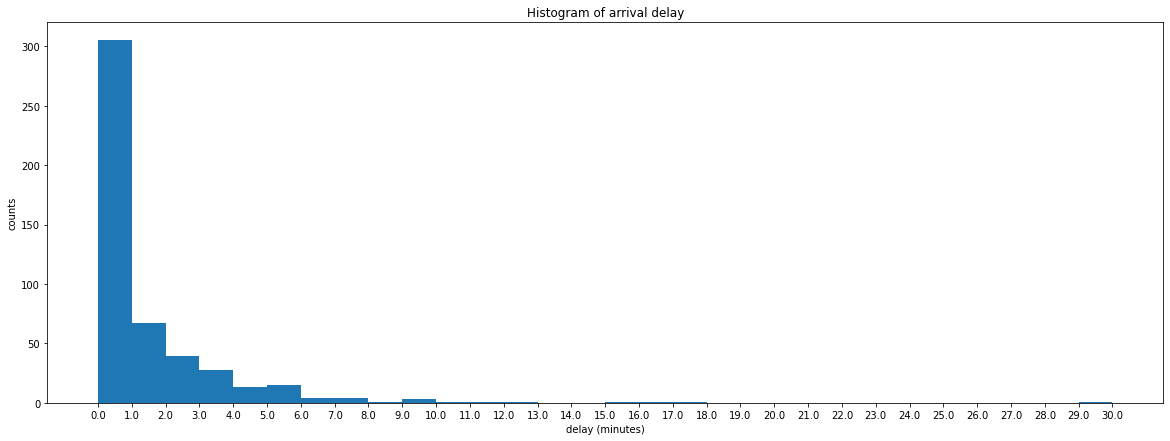

In [12]:
# for arrival
query = '''
    with Times as(
        select unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yy HH:mm') as expected, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yy HH:mm:ss') as actual
        from {0}.sbb_IC733_LAU
        where upper(AN_PROGNOSE_STATUS) like 'REAL'
    )
    select (actual - expected) as arr_delay from Times
'''.format(username)
LAU_IC_arrdelay = pd.read_sql(query, conn)
LAU_IC_arrdelay.loc[LAU_IC_arrdelay['arr_delay'] < 0, 'arr_delay'] = 0

plt.figure(figsize=(20, 7))
plt.hist(LAU_IC_arrdelay.arr_delay, bins=range(0, max(LAU_IC_arrdelay.arr_delay) + 60, 60))
plt.xticks(range(0, max(LAU_IC_arrdelay.arr_delay) + 60, 60),labels = [x/60 for x in range(0, max(LAU_IC_arrdelay.arr_delay) + 60, 60)])
plt.xlabel("delay (minutes)")
plt.ylabel("counts")
plt.title("Histogram of arrival delay")
plt.show()

**Answer**
- Delay in 1 minutes is the most frequent. 
- There are also some cases with delay between 1 and 4 minutes. 
- Long time delays exist though the number of this kind of cases is few. 
- The longest delay is around 29 minutes.

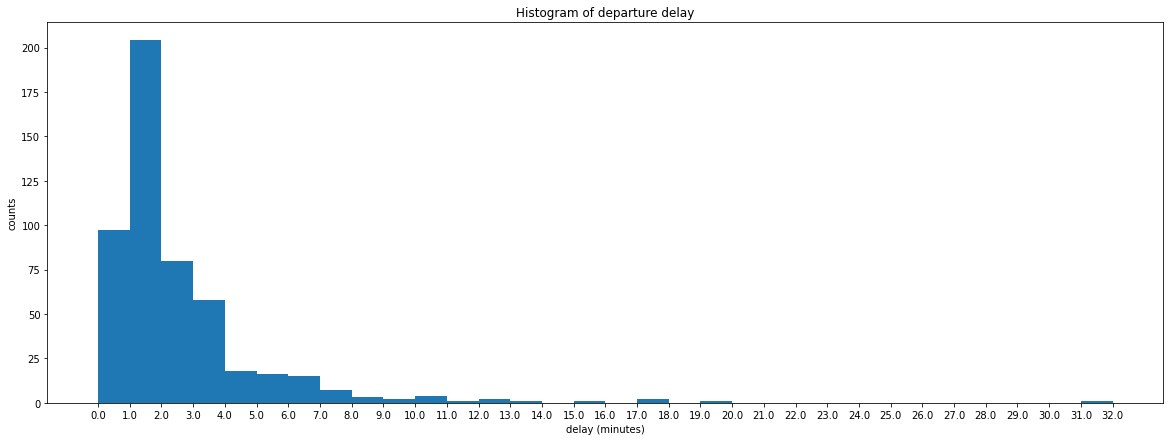

In [13]:
# for departure
query = '''
    with Times as(
        select unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') as actual
        from {0}.sbb_IC733_LAU
        where upper(AB_PROGNOSE_STATUS) like 'REAL'
    )
    select (actual - expected) as dep_delay from Times
'''.format(username)
LAU_IC_depdelay = pd.read_sql(query,conn)
LAU_IC_depdelay.loc[LAU_IC_depdelay['dep_delay'] <0,'dep_delay' ] = 0

plt.figure(figsize=(20,7))
plt.hist(LAU_IC_depdelay.dep_delay, bins=range(0, max(LAU_IC_depdelay.dep_delay) + 60, 60))
plt.xticks(range(0, max(LAU_IC_depdelay.dep_delay) + 60, 60),labels = [x/60 for x in range(0, max(LAU_IC_depdelay.dep_delay) + 60, 60)])
plt.xlabel("delay (minutes)")
plt.ylabel("counts")
plt.title("Histogram of departure delay")
plt.show()

**Answer**
- The delay between 1-2 minutes is most frequent. 
- There are also quite a large number of delays within 1 minutes and between 2 to 6 minutes. 
- The delay over 10 minutes are more often than the arrival delay. 
- The longest delay is also longer than the arrival one, which is over 31 minutes. 
- The total number of departure delays seems to be more than the arrival one.

ii) Compute the 50th and 75th percentiles of delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. Which trains are the most disrupted? Can you find the tendency and interpret?

In [15]:
# Create table for all trains at Geneve
query = """
    drop table if exists {0}.sbb_GV
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_GV
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Genève' and lower(PRODUKT_ID) like 'zug' 
""".format(username)
cur.execute(query)

First, let's create the table indicating their delay percentiles for these trains.

In [16]:
# for arrival
# delay shown in seconds

query = """
    with Times as(
        select if(unix_timestamp(AN_PROGNOSE, 'dd.MM.yy HH:mm:ss') < unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yy HH:mm'), 0, 
                  unix_timestamp(AN_PROGNOSE, 'dd.MM.yy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yy HH:mm')) as delay,
               LINIEN_ID as id
        from {0}.sbb_GV
        where upper(AN_PROGNOSE_STATUS) like 'REAL' and VERKEHRSMITTEL_TEXT like 'IC'
        and LINIEN_ID in (702,704,706,708,710,712,714,716,718,720,722,724,726,728,730)
    )
    select id, percentile(delay, 0.5) as delay_50, percentile(delay, 0.75) as delay_75 from Times
    group by id
    order by id
""".format(username)
GV_arrdelay = pd.read_sql(query,conn)
GV_arrdelay

,id,delay_50,delay_75
0,702,12.0,82.25
1,704,39.0,129.00
2,706,37.0,138.00
3,708,62.0,219.50
4,710,26.0,127.75
5,712,7.0,76.00
6,714,13.0,87.50
7,716,13.0,88.00
8,718,1.0,76.50
9,720,12.0,71.00


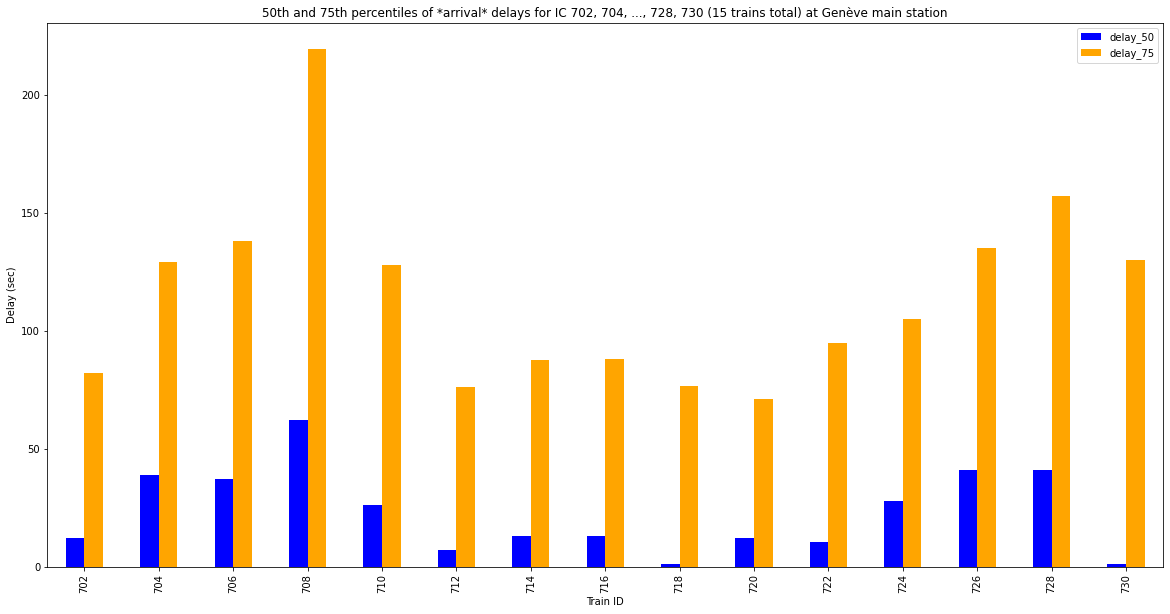

In [17]:
# visualize the bar chart
GV_arrdelay.plot.bar(x='id', figsize=(20,10), color = ['blue', 'orange', 'red'])
plt.xlabel("Train ID")
plt.ylabel("Delay (sec)")
plt.title("50th and 75th percentiles of *arrival* delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station")
plt.show()

In [19]:
# for departure
# delay shown in seconds

query = """
    with Times as(
        select if(unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') < unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm'), 0, 
                  unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm')) as delay,
               LINIEN_ID as id
        from {0}.sbb_GV
        where upper(AB_PROGNOSE_STATUS) like 'REAL' and VERKEHRSMITTEL_TEXT like 'IC'
        and LINIEN_ID in (702,704,706,708,710,712,714,716,718,720,722,724,726,728,730)
    )
    select id, percentile(delay, 0.5) as delay_50, percentile(delay, 0.75) as delay_75 from Times
    group by id
    order by id
""".format(username)
GV_depdelay = pd.read_sql(query,conn)
GV_depdelay

,id,delay_50,delay_75
0,702,63.0,95.75
1,704,107.5,192.00
2,706,95.5,185.75
3,708,118.5,249.00
4,710,79.0,157.00
5,712,84.0,140.25
6,714,77.0,145.00
7,716,69.5,129.75
8,718,65.5,118.00
9,720,77.0,123.00


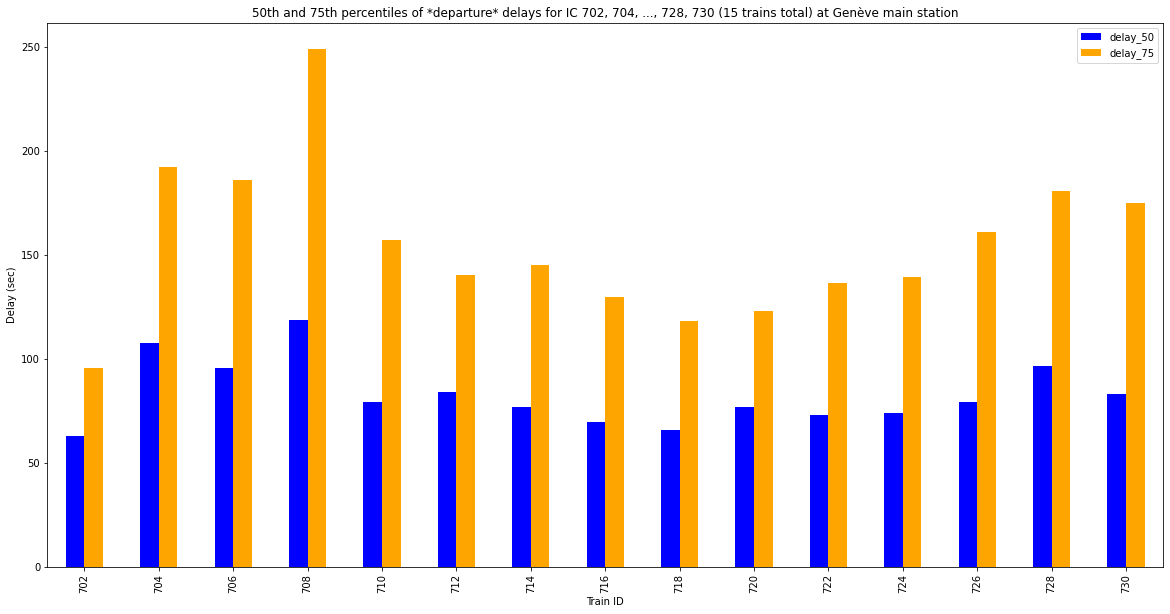

In [20]:
GV_depdelay.plot.bar(x='id', figsize=(20,10), color = ['blue', 'orange', 'red'])
plt.xlabel("Train ID")
plt.ylabel("Delay (sec)")
plt.title("50th and 75th percentiles of *departure* delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station")
plt.show()

**Answer**

- (Arrival Delay) 
With respect to the 50th and 75th percentiles, train 708 is the most disrupted because it has higher arrival delay than the others.

- (Departure Delay) 
Similarly, train 708 has the largest departure delay compared with the other trains. 
To sum up, based on the 50th and 75th percentiles of the arrival and departure delays, train 708 is the most disrupted one. 

Regarding the schedule from SBB, train 708 departs and arrives at 9:42 and 10:18 respectively. Therefore, the delay cause of train 708 is because it runs in the rush hour of a day.

Similar phenomenon can be observed for train 728, which departs and arrives at 19:42 and 20:18 respectively, which are within the evening rush hours.


iii) Compute 25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within **each hour** and visualize your results. Can you find the tendency and interpret?

In [21]:
# for departure
query = '''
    with Times_ori as(
        select if(unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') < unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm'), 0, 
                unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm')) as delay,
            substr(ABFAHRTSZEIT, 12, 2) as schedule_hour
        from {0}.sbb_LAU
        where upper(AB_PROGNOSE_STATUS) like 'REAL'
    )
    select schedule_hour, percentile(delay, 0.25) as delay_25,
        percentile(delay, 0.5) as delay_50, percentile(delay, 0.75) as delay_75
        from Times_ori
    group by schedule_hour
    order by schedule_hour
'''.format(username)
LAU_depdelay = pd.read_sql(query,conn)

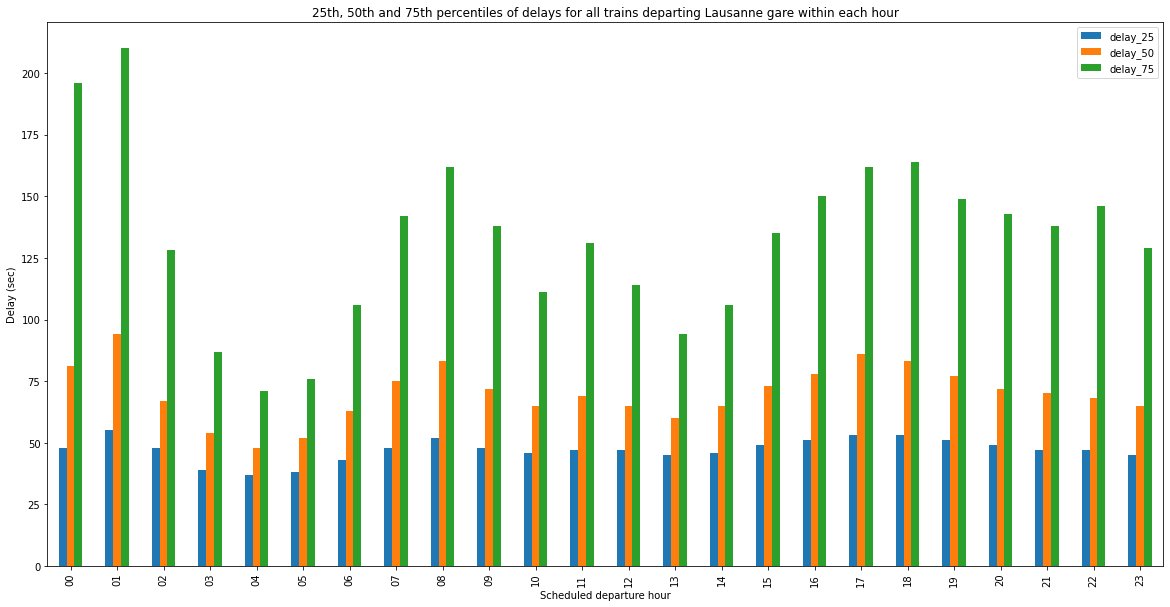

In [22]:
LAU_depdelay.plot.bar(x='schedule_hour', figsize=(20,10))
plt.xlabel("Scheduled departure hour")
plt.ylabel("Delay (sec)")
plt.title("25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within each hour")
plt.show()

**Answer**

- Within all hours, delays happen most of the time. 
- Trains delay the most when departing at 7 to 9 in the morning and 16 to 19 in the evening, this is expected since these are rush hours.

iv) Did you notice something "strange"? Can you try to find the reasons behind that? Feel free to check it out from different perspectives.

**Answer**
- From the chart above, the largest delay occurs during mid-night, which is weird because less trains are scheduled in the mid-night than other time.

In [39]:
query = """
    drop table if exists {0}.sbb_tmp_tmp
""".format(username)
cur.execute(query)

query = """
create table {0}.sbb_tmp_tmp
stored as orc
as 
    with Times_ori as(
        select if(unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') < unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm'), 0, 
                unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm')) as delay,
            substr(ABFAHRTSZEIT, 12, 2) as schedule_hour, concat(VERKEHRSMITTEL_TEXT, LINIEN_ID) as ID
        from {0}.sbb_LAU
        where upper(AB_PROGNOSE_STATUS) like 'REAL'
    )
    select ID, schedule_hour, delay
    from Times_ori
""".format(username)
cur.execute(query)
# LAU_dep = pd.read_sql(query, conn)

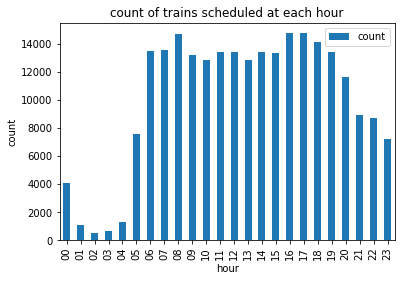

In [44]:
query = """
    select schedule_hour, count(ID) as count
    from {0}.sbb_tmp_tmp
    group by schedule_hour
    order by schedule_hour
""".format(username)
LAU_dep = pd.read_sql(query, conn)
LAU_dep.plot.bar(x='schedule_hour')
plt.title('count of trains scheduled at each hour')
plt.xlabel('hour')
plt.ylabel('count')
plt.show()

Indeed, the number of trains at midnight is much less than the other hours.

There are very few passengers at midnight, so SBB may not care about the punctuality at this time. 

### Question I.f - 15 Points

If the departure time of one train is delayed, can it catch up with the schedule at a later station? Select __at least 2 trains from Genève (main station) to Lausanne gare__ as examples. Think about what kind of trains you want to select, direct or indirect (having stops in between), at rush hour or in midnight? Use HiveQL to select relevant data and show the results with a proper plot of arrival delay at Lausanne versus departure delay at Genève. Document and discuss your findings.

__Note__: you can write some helper functions to generate the query for you.

**Here we compare trains in mid-night with those in rush hours**

In [31]:
# create table of trains from Geneve to Lausanne with departure delay in the year 2019
query = """
    drop table if exists {0}.sbb_GV_LAU
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_GV_LAU
    stored as orc
    as 
        with tmp_GV as (
            select BETRIEBSTAG as xdate, concat(VERKEHRSMITTEL_TEXT, LINIEN_ID) as ID, ABFAHRTSZEIT as dep, AB_PROGNOSE as actual_dep,
                    unix_timestamp(AB_PROGNOSE, 'dd.MM.yy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yy HH:mm') as dep_delay
            from {0}.sbb_GV where BETRIEBSTAG like '%2019'
        ),
        tmp_LAU as(
            select BETRIEBSTAG as xdate, concat(VERKEHRSMITTEL_TEXT, LINIEN_ID) as ID, ANKUNFTSZEIT as arr, AN_PROGNOSE as actual_arr,
                    unix_timestamp(AN_PROGNOSE, 'dd.MM.yy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yy HH:mm') as arr_delay
            from {0}.sbb_LAU where BETRIEBSTAG like '%2019'
        ) 
        select tmp_GV.xdate as xdate,
               tmp_GV.ID as ID,
               tmp_GV.dep as GV_dep,
               tmp_GV.actual_dep as GV_act_dep,
               tmp_GV.dep_delay as dep_delay, 
               tmp_LAU.arr as LAU_arr,
               tmp_LAU.actual_arr as LAU_act_arr,
               tmp_LAU.arr_delay as arr_delay 
        from tmp_GV, tmp_LAU
        where tmp_GV.ID = tmp_LAU.ID
          and tmp_GV.xdate = tmp_LAU.xdate
          and unix_timestamp(tmp_GV.actual_dep,'dd.MM.yy HH:mm:ss') < unix_timestamp(tmp_LAU.actual_arr,'dd.MM.yy HH:mm:ss') 
          and tmp_GV.dep_delay > 0
""".format(username)
cur.execute(query)

In [32]:
# retrieve ratio of trips without arrival delay
#        & ratio of average arrival delay (negative delay regarded as 0) versus average departure delay
# for each train in mid-night (0AM to 5AM) that has departure delay
#
# count(if(arr_delay <= 0, 1, null)) => hack to get count of trips without delay
# count() don't count only when the expr at the row is null
#
# Remove trains with <= 10 trips to get meaningful ratio_no_arr_delay
query = """
    with ori_tab as(
        select ID as train,
               substr(gv_dep, 12, 2) as schedule_hour, 
               count(*) as total_cnt,
               count(if(arr_delay <= 0, 1, null)) as cnt_no_arr_delay,
               count(if(arr_delay <= 0, 1, null)) / count(*) as ratio_no_arr_delay,
               avg(dep_delay) as avg_dep_delay,
               avg(if(arr_delay > 0, arr_delay, 0)) as avg_arr_delay,
               avg(if(arr_delay > 0, arr_delay, 0)) / avg(dep_delay) as ratio_avg_arr_vs_dep_delay
        from {0}.sbb_GV_LAU
        where substr(gv_dep, 12, 2) >= '00' and substr(gv_dep, 12, 2) <= '05'
        group by ID, substr(gv_dep, 12, 2)
    )
    select * from ori_tab
    where total_cnt > 10
""".format(username)
df_delay_info_midnight = pd.read_sql(query,conn)

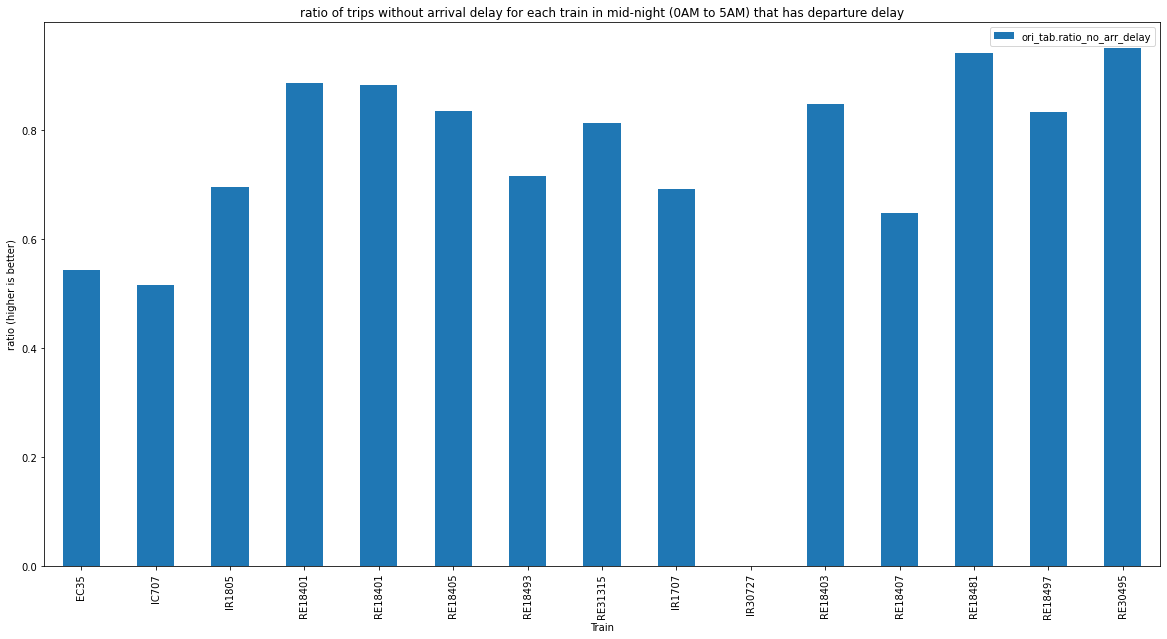

In [33]:
df_delay_info_midnight.plot.bar(x='ori_tab.train', y='ori_tab.ratio_no_arr_delay', figsize=(20,10))
plt.xlabel("Train")
plt.ylabel("ratio (higher is better)")
plt.title("ratio of trips without arrival delay for each train in mid-night (0AM to 5AM) that has departure delay")
plt.show()

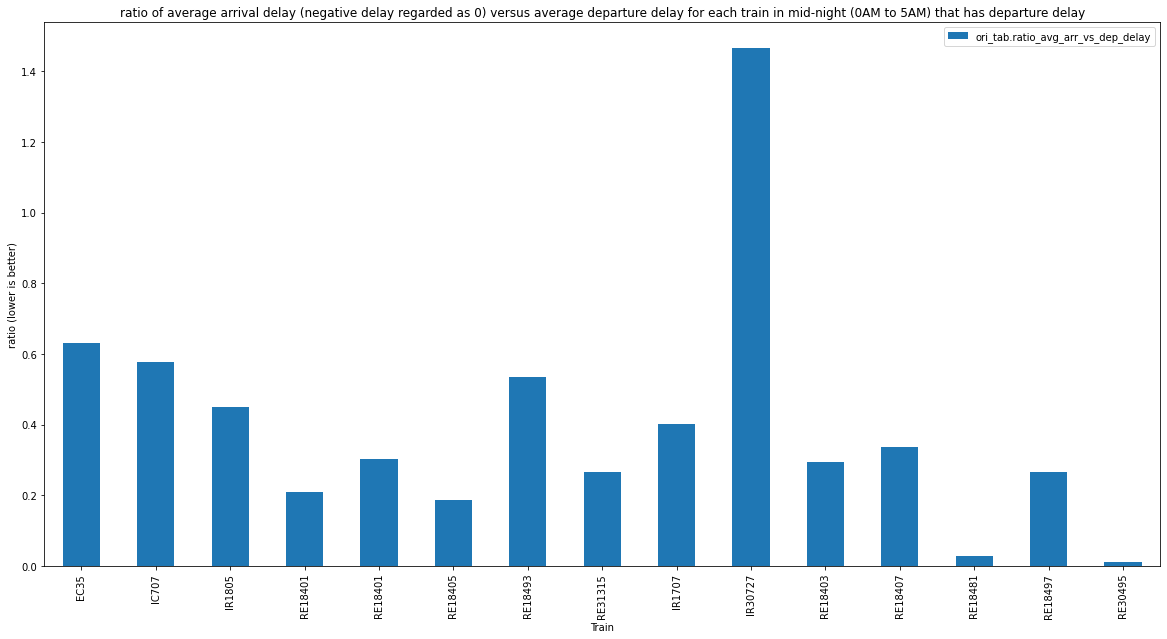

In [34]:
df_delay_info_midnight.plot.bar(x='ori_tab.train', y='ori_tab.ratio_avg_arr_vs_dep_delay', figsize=(20,10))
plt.xlabel("Train")
plt.ylabel("ratio (lower is better)")
plt.title("ratio of average arrival delay (negative delay regarded as 0) versus average departure delay for each train in mid-night (0AM to 5AM) that has departure delay")
plt.show()

In [35]:
# retrieve ratio of trips without arrival delay
#        & ratio of average arrival delay (negative delay regarded as 0) versus average departure delay
# for each train in rush hour (8AM or 6PM) that has departure delay
#
# count(if(arr_delay <= 0, 1, null)) => hack to get count of trips without delay
# count() don't count only when the expr at the row is null
#
# Remove trains with <= 10 trips to get meaningful ratio_no_arr_delay
query = """
    with ori_tab as(
        select ID as train,
               substr(gv_dep, 12, 2) as schedule_hour, 
               count(*) as total_cnt,
               count(if(arr_delay <= 0, 1, null)) as cnt_no_arr_delay,
               count(if(arr_delay <= 0, 1, null)) / count(*) as ratio_no_arr_delay,
               avg(dep_delay) as avg_dep_delay,
               avg(if(arr_delay > 0, arr_delay, 0)) as avg_arr_delay,
               avg(if(arr_delay > 0, arr_delay, 0)) / avg(dep_delay) as ratio_avg_arr_vs_dep_delay
        from {0}.sbb_GV_LAU
        where substr(gv_dep, 12, 2) like '08' or substr(gv_dep, 12, 2) like '18'
        group by ID, substr(gv_dep, 12, 2)
    )
    select * from ori_tab
    where total_cnt > 10
""".format(username)
df_delay_info_rush_hour = pd.read_sql(query,conn)

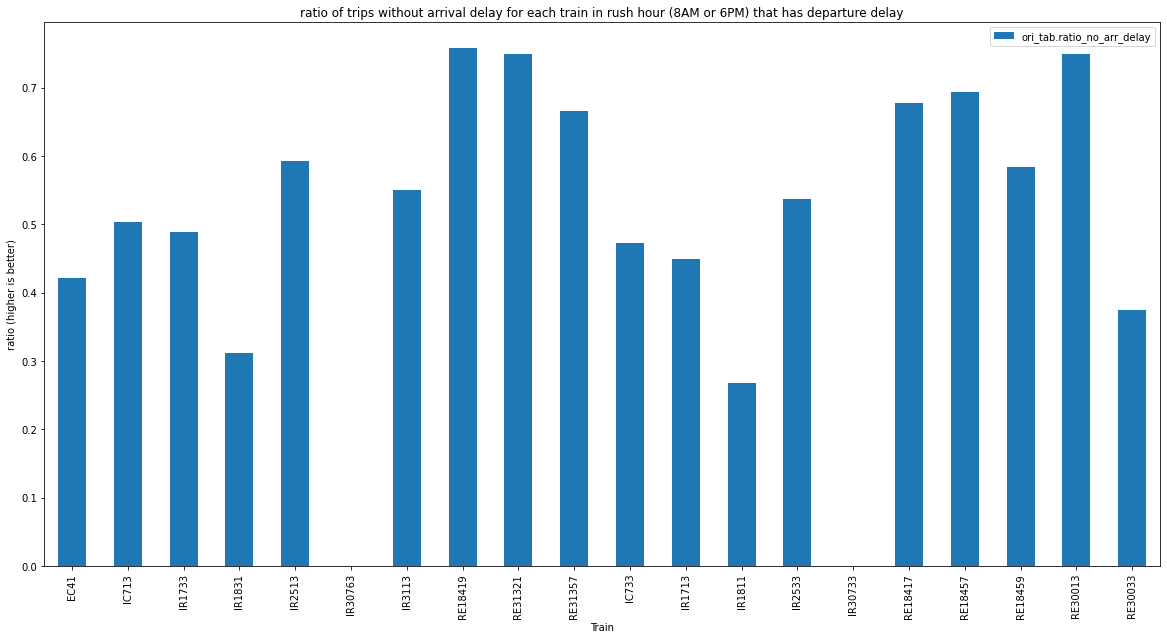

In [36]:
df_delay_info_rush_hour.plot.bar(x='ori_tab.train', y='ori_tab.ratio_no_arr_delay', figsize=(20,10))
plt.xlabel("Train")
plt.ylabel("ratio (higher is better)")
plt.title("ratio of trips without arrival delay for each train in rush hour (8AM or 6PM) that has departure delay")
plt.show()

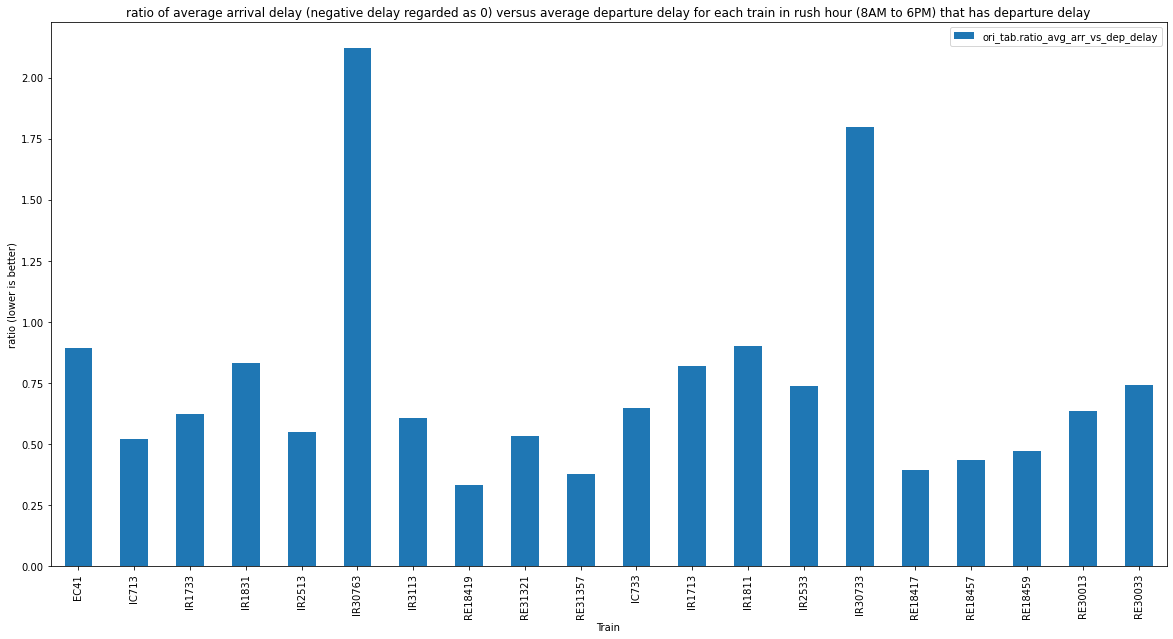

In [37]:
df_delay_info_rush_hour.plot.bar(x='ori_tab.train', y='ori_tab.ratio_avg_arr_vs_dep_delay', figsize=(20,10))
plt.xlabel("Train")
plt.ylabel("ratio (lower is better)")
plt.title("ratio of average arrival delay (negative delay regarded as 0) versus average departure delay for each train in rush hour (8AM to 6PM) that has departure delay")
plt.show()

**Answer**
From the graphs above, we observe the following:
1. Most trains departured from Geneve in midnight (0:00 to 5:00) with delay can catch up with schedule in Lausanne with 60% to 80% chance, and their arrival delay is usually less then 40% of their departure delay.

2. Most trains departured from Geneve in rush hour (8:00 or 18:00) with delay can catch up with schedule in Lausanne with 40% to 60% chance, and their arrival delay is usually 50% to 75% of their departure delay.

The above findings show that trains are more likely to catch up with their schedule in Lausanne if they are delayed in Geneve, this is expected since in rush hours there are much more passengers which the train must wait in the stops between Lausanne and Geneve. There are also more trains in rush hour which could complicate scheduling of trains and make catch-up harder.